# Explore the value of `land_adj_sedfrac_min`

A minimum percentage of each grid cell that is sediments (`land_adj_sedfrac_min`) is applied to all land-adjacent grid cells.

This notebook compares the implications of the value of `land_adj_sedfrac_min` for each grid.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from itertools import product

import numpy as np
import xarray as xr

import matplotlib.pyplot as plt

import pop_tools
import util

Cannot write to data cache '/glade/p/cesmdata/cseg'. Will not be able to download remote data files. Use environment variable 'CESMDATAROOT' to specify another directory.


## Parameters

In [7]:
land_adj_sedfrac_mins = {
    'POP_gx3v7': 0.015, 
    'POP_gx1v7': 0.03,
    'POP_tx0.1v3': 0.18, 
}
land_adj_sedfrac_mins

{'POP_gx3v7': 0.015, 'POP_gx1v7': 0.03, 'POP_tx0.1v3': 0.18}

## Read the grids

In [3]:
grids = {}
for dst_grid in util.POP_grids:
    grids[dst_grid] = pop_tools.get_grid(dst_grid)

## Prepare `fesedfrac`

## Read pre-computed [`fesedfrac`](_sedfrac_compute.ipynb)

In [6]:
sedfracs = {}
for dst_grid in util.POP_grids:
    with xr.open_dataset(util.sedfrac_file(dst_grid)) as dstmp:
        sedfracs[dst_grid] = dstmp.sedfrac.reset_index('z_t', drop=True).compute()

### Determine land-adjacent points and apply `land_adj_sedfrac_min`

In [4]:
land_adjacent = {}
for dst_grid in util.POP_grids:
    land_adjacent[dst_grid] = util.compute_land_adjacent_points(dst_grid)

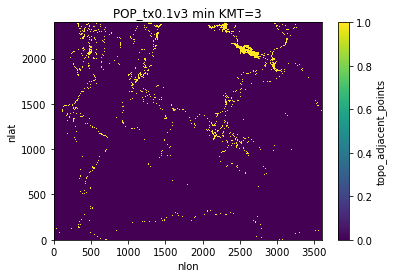

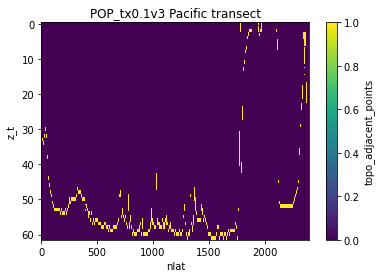

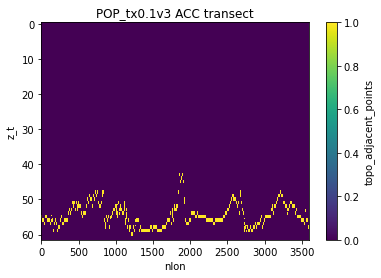

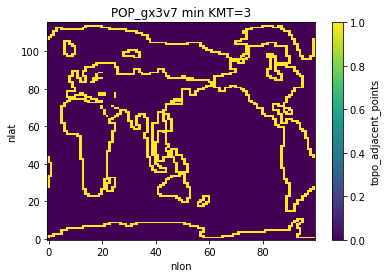

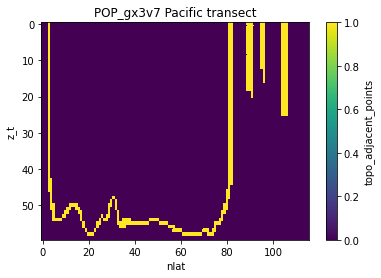

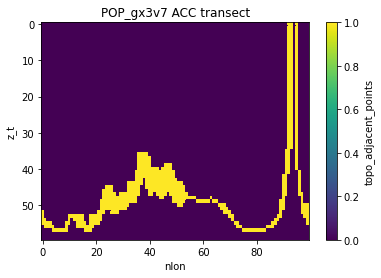

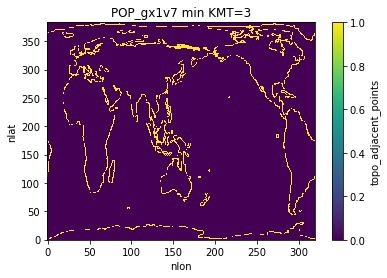

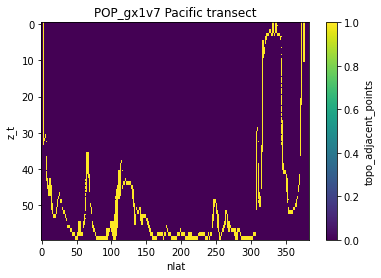

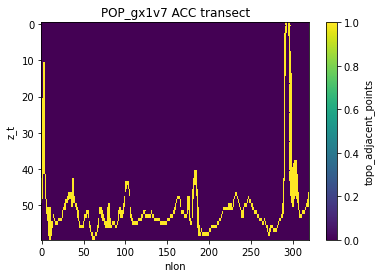

In [5]:
for dst_grid in util.POP_grids:
    i_pacific = util.nlon_pacific_xsection[dst_grid]
    j_acc = util.nlat_acc_xsection[dst_grid]
    
    plt.figure()
    land_adjacent[dst_grid].isel(z_t=2).plot()
    h = plt.title(f'{dst_grid} min KMT={3}')

    plt.figure()
    land_adjacent[dst_grid].isel(nlon=i_pacific).plot(yincrease=False)
    h = plt.title(f'{dst_grid} Pacific transect')

    plt.figure()
    land_adjacent[dst_grid].isel(nlat=j_acc).plot(yincrease=False)
    h = plt.title(f'{dst_grid} ACC transect')

In [8]:
sedarea_totals = {}
for dst_grid in util.POP_grids:
        sedarea_totals[dst_grid] = (
            sedfracs[dst_grid] * grids[dst_grid].TAREA
        ).sum().values
sedarea_totals 

{'POP_tx0.1v3': array(3.6013616e+18),
 'POP_gx3v7': array(3.60334734e+18),
 'POP_gx1v7': array(3.6048284e+18)}

In [9]:
sedarea_profile = {}
for dst_grid in util.POP_grids:
        sedarea_profile[dst_grid] = (
            sedfracs[dst_grid] * grids[dst_grid].TAREA
        ).sum(
            ['nlat', 'nlon']
        ).assign_coords(
            z_t=grids[dst_grid].z_t
        )
        sedarea_profile[dst_grid].attrs['long_name'] = 'Area'
        sedarea_profile[dst_grid].attrs['units'] = 'cm^2'


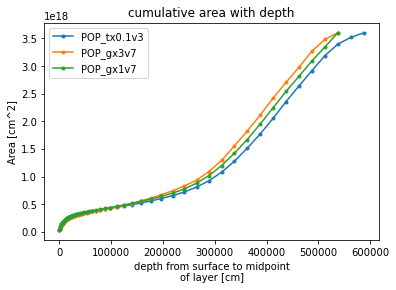

In [10]:
for dst_grid in util.POP_grids:
    (sedarea_profile[dst_grid].cumsum('z_t')).plot(
        marker='.',
        label=dst_grid,
    )
    
plt.legend();
plt.title('cumulative area with depth');

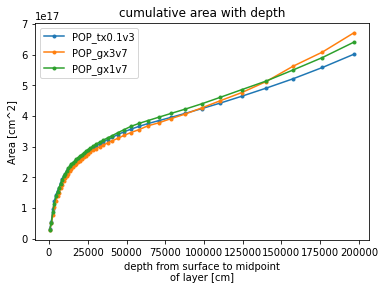

In [11]:
for dst_grid in util.POP_grids:
    (sedarea_profile[dst_grid].sel(z_t=slice(0, 2000e2)).cumsum('z_t')).plot(
        marker='.',
        label=dst_grid,
    )
    
plt.legend();
plt.title('cumulative area with depth');

In [14]:
sedfrac_mods = {}
for dst_grid in util.POP_grids:
    sedfrac_mods[dst_grid] = util.apply_land_adj_sedfrac_min(
         sedfracs[dst_grid], 
         land_adjacent[dst_grid], 
         land_adj_sedfrac_mins[dst_grid],
    )
    

In [15]:
sedarea_totals = {}
for dst_grid in util.POP_grids:
        sedarea_totals[dst_grid] = (
            sedfrac_mods[dst_grid] * grids[dst_grid].TAREA
        ).sum().values
sedarea_totals 

{'POP_tx0.1v3': array(3.95881849e+18),
 'POP_gx3v7': array(3.84783777e+18),
 'POP_gx1v7': array(3.80739043e+18)}

In [16]:
sedarea_mod_profile = {}
for dst_grid in util.POP_grids:
        sedarea_mod_profile[dst_grid] = (
            sedfrac_mods[dst_grid] * grids[dst_grid].TAREA
        ).sum(
            ['nlat', 'nlon']
        ).assign_coords(
            z_t=grids[dst_grid].z_t
        )
        sedarea_profile[dst_grid].attrs['long_name'] = 'Area'
        sedarea_profile[dst_grid].attrs['units'] = 'cm^2'


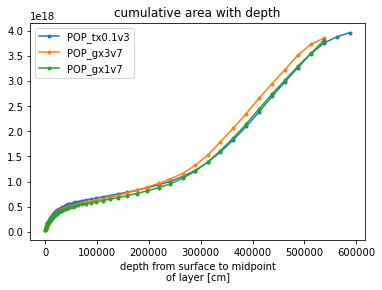

In [17]:
for dst_grid in util.POP_grids:
    (sedarea_mod_profile[dst_grid].cumsum('z_t')).plot(
        marker='.',
        label=dst_grid,
    )
    
plt.legend();
plt.title('cumulative area with depth');

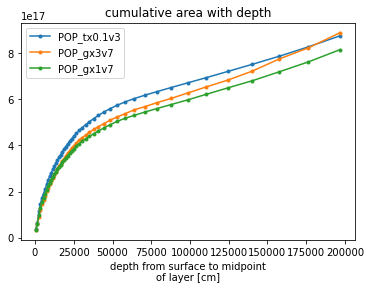

In [18]:
for dst_grid in util.POP_grids:
    (sedarea_mod_profile[dst_grid].sel(z_t=slice(0, 2000e2)).cumsum('z_t')).plot(
        marker='.',
        label=dst_grid,
    )
    
plt.legend();
plt.title('cumulative area with depth');